In [1]:
notebook_id = "210"

<a id="ID_top"></a>
## Adjacency matrix and network chart

This workflow takes live files and calls on functions in `script_adj_matrix_plot.py` to create adjancency matrices and network graph

#### Notebook sections:
    
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

### Packages

In [2]:
# %load s_package_import
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
import zipfile #notebook

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import pycountry

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
import gme as gme

#=== distance datasets
import wbdata


/Users/antonios/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Import module and declare path variables
`import s_filepaths.py`

In [3]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_image = s_filepaths.path_images

<a id="ID_part2"></a>
### Part 2 | Load files
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [4]:
# list of all files
os.listdir(path_live)

# list of file names that can be read with same rule
filename = "125_input_scope_country.csv.gzip"

Load data directly from compressed file to avoid GitHub issues with storage

In [5]:
# Load data
df_network_country = pd.read_csv(f"{path_live}{filename}",compression= "gzip")
df_network_country.head()

,year,country_d,iso3_d,dynamic_code_d,landlocked_d,island_d,region_d,gdp_pwt_const_d,pop_d,lat_d,lng_d,country_o,iso3_o,dynamic_code_o,landlocked_o,island_o,region_o,pop_o,lat_o,lng_o,contiguity,distance,bri_year_d,bri_flag_d,economic_distance,institutional_distance
0,2016,United Arab Emirates,ARE,ARE,0,0,middle_east,NaN,NaN,25.094378,55.454674,Portugal,PRT,PRT,0,0,europe,NaN,39.310741,-10.883486,0,6154.4214,2017.0,1.0,1.047448e+09,0.028180
1,2016,Azerbaijan,AZE,AZE,0,0,europe,NaN,NaN,40.362438,47.255833,Kuwait,KWT,KWT,0,0,middle_east,NaN,29.279369,47.930035,0,1236.6086,2015.0,1.0,9.189585e+08,0.151204
2,2016,Belgium,BEL,BEL,0,0,europe,NaN,NaN,50.691814,4.581812,Cambodia,KHM,KHM,0,0,south_east_asia,NaN,12.320902,104.874400,0,9693.0625,NaN,NaN,2.019057e+09,3.941229
3,2016,China,CHN,CHN,0,0,east_asia,NaN,NaN,35.389668,114.002470,Belarus,BLR,BLR,1,0,europe,NaN,53.604687,27.802185,0,6904.3364,2013.0,1.0,1.724850e+07,0.000004
4,2016,Spain,ESP,ESP,0,0,europe,NaN,NaN,39.231297,-4.263840,Belgium,BEL,BEL,0,0,europe,NaN,50.691814,4.581812,0,1374.9351,NaN,NaN,1.282899e+08,0.586379


### Prepare data for visualisation

In [6]:
# returns adjancecy matrix [position 0] and list of pairs [1]
array_adjacency = s_adj_matrix_plot.f_adj_matrix(df_network_country,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")

Start-up report | Two different equal count (77) columns are used.


In [7]:
def f_adj_matrix(p_df,p_col,p_index,p_contiguity_flag = 1,p_col_full = None,p_index_full = None):
    """Function returns an adjecency matrix and a list of tuples with the combination of countries
    that are contiguous based on a binary column in the input dataframe.

    Input dataframe should ONLY contain unique combinations as no filtering or checks will be done.

    p_col : define column key (string) that will serve as column list in adjacency matrix
    p_index : define column key (string) that will serve as index/rows list in adjacency matrix

    p_col and p_index can use the same string if required
    """
    
    #=== Set up variables

    # create working raw dataframe and sort
    f_df = p_df.copy()
    f_df.sort_values(by = [p_col,p_index], inplace = True)

    # unique values for both column keys
    s_rep_col = list(f_df.loc[:,p_col].unique())
    s_rep_ind = list(f_df.loc[:,p_index].unique())

    # sort lists
    s_rep_col.sort()
    s_rep_ind.sort()

    #=== Check in reporting:
    # if columns used for adj matrix are both for both axes
    if p_col == p_index:
        start_report = f"There are {len(p_df.loc[:,p_col].unique())} unique value(s) from one column key ('{p_col}')."
    else:
        # check if their lengths are equal
        if len(s_rep_col) == len(s_rep_ind):
            s_rep_equal = f"equal count ({len(s_rep_col)})"
        else:
            s_rep_equal = f"unequal count (col: {len(s_rep_col)} index: {len(s_rep_ind)})"

        start_report = f"Two different {s_rep_equal} columns are used."

    print(f"Start-up report | {start_report}")

    #=== create zeroed dataframe
    f_df_am = pd.DataFrame(np.zeros(shape = (len(s_rep_ind),len(s_rep_col))),columns = s_rep_col,index = s_rep_ind)

    #=== populate adjacency matrix dataframe and create list of tuples

    # list of tuples to return
    f_list_of_neighbours = []

    # Check if separate tuple values are needed
    if p_col_full is None:
        f_tuple_col = p_col
    else:
        f_tuple_col = p_col_full

    if p_index_full is None:
        f_tuple_ind = p_index
    else:
        f_tuple_ind = p_index_full

    # for loop through every destination
    for destination in s_rep_col:

        # filter based on country code/index/value in column
        f_for_df_filter = f_df[f_df.loc[:,p_col] == destination].copy()

        # (tuple) full name of the country
        f_for_df_full_name = list(f_for_df_filter.loc[:,f_tuple_col].unique())[0]

        # (adj. matrix) only those that are contiguous
        f_for_df_filter = f_for_df_filter[f_for_df_filter.contiguity == p_contiguity_flag].copy()
        # (adj. matrix) list of all neighbouring countries
        f_neighbour_countries = list(f_for_df_filter.loc[:,p_index])
        # (adj. matrix) set values to '1'
        f_df_am.loc[f_neighbour_countries,destination] = 1

        # (tuple) save pairings as a tuple
        f_temp_tuple = (f_for_df_full_name,list(f_for_df_filter.loc[:,f_tuple_ind]))
        f_list_of_neighbours.append(f_temp_tuple)

    # unique list of countries
    f_unique_country_col = list(f_df.loc[:,f_tuple_col].unique())
    f_unique_country_ind = list(f_df.loc[:,f_tuple_ind].unique())
    f_unique_country_list = list(set(f_unique_country_col+f_unique_country_ind))
    f_unique_country_list.sort()

    return_values = [f_df_am,f_list_of_neighbours,f_unique_country_list,f_for_df_full_name]

    return return_values

In [8]:
# returns adjancecy matrix [position 0] and list of pairs [1]
array_adjacency = f_adj_matrix(df_network_country,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")

Start-up report | Two different equal count (77) columns are used.


In [9]:
array_adjacency[1][0]

('Afghanistan',
 ['China', 'Iran', 'Pakistan', 'Tajikistan', 'Turkmenistan', 'Uzbekistan'])

In [10]:
df_network_country.head()

,year,country_d,iso3_d,dynamic_code_d,landlocked_d,island_d,region_d,gdp_pwt_const_d,pop_d,lat_d,lng_d,country_o,iso3_o,dynamic_code_o,landlocked_o,island_o,region_o,pop_o,lat_o,lng_o,contiguity,distance,bri_year_d,bri_flag_d,economic_distance,institutional_distance
0,2016,United Arab Emirates,ARE,ARE,0,0,middle_east,NaN,NaN,25.094378,55.454674,Portugal,PRT,PRT,0,0,europe,NaN,39.310741,-10.883486,0,6154.4214,2017.0,1.0,1.047448e+09,0.028180
1,2016,Azerbaijan,AZE,AZE,0,0,europe,NaN,NaN,40.362438,47.255833,Kuwait,KWT,KWT,0,0,middle_east,NaN,29.279369,47.930035,0,1236.6086,2015.0,1.0,9.189585e+08,0.151204
2,2016,Belgium,BEL,BEL,0,0,europe,NaN,NaN,50.691814,4.581812,Cambodia,KHM,KHM,0,0,south_east_asia,NaN,12.320902,104.874400,0,9693.0625,NaN,NaN,2.019057e+09,3.941229
3,2016,China,CHN,CHN,0,0,east_asia,NaN,NaN,35.389668,114.002470,Belarus,BLR,BLR,1,0,europe,NaN,53.604687,27.802185,0,6904.3364,2013.0,1.0,1.724850e+07,0.000004
4,2016,Spain,ESP,ESP,0,0,europe,NaN,NaN,39.231297,-4.263840,Belgium,BEL,BEL,0,0,europe,NaN,50.691814,4.581812,0,1374.9351,NaN,NaN,1.282899e+08,0.586379


In [21]:
def f_graph(p_tuples,p_df,p_group_of_countries = None,p_colour_group = "yellow", p_colour_default = "blue", p_edge_colour = "red",p_seed = None, p_weight = None):

    """This function takes in the list of tuples from f_adj_matrix() (should be at index [1])
    Plus list of countries (full name, i.e. country_o or country_d columns) for colournig, else defaults to blue nodes"""
    import networkx as nx

    #=== Set up network
    f_G = nx.Graph()

    # Add nodes based on full country names
    #f_G.add_nodes_from(p_uniques)

    #=== base for checking nodes and edges
    def f_add_node_and_edge(p_graph,p_central_node,p_node_list,p_length = 5):
        # list of edges
        temp_edges = []
        # list of neighbours
        p_node_list

        try:
            p_graph.add_node(p_central_node)
        except:
            pass

        for country in p_node_list:
            temp_tuple = (p_central_node,country)
            temp_edges.append(temp_tuple)
            
            try:
                temp_length = p_df[(p_df.country_d == temp_tuple[0]) & (p_df.country_o == temp_tuple[1])].distance.values
                temp_di = p_df[(p_df.country_d == temp_tuple[0]) & (p_df.country_o == temp_tuple[1])].institutional_distance.values
                temp_de = p_df[(p_df.country_d == temp_tuple[0]) & (p_df.country_o == temp_tuple[1])].economic_distance.values
            except:
                pass
            
            p_graph.add_edge(temp_tuple[0], temp_tuple[1], length=temp_length[0], de = temp_de[0], di = temp_di[0])

        #p_graph.add_edges_from(temp_edges,length = p_length)

    #=== run function to add values
    for entry in p_tuples:
        f_add_node_and_edge(f_G,entry[0],entry[1])

    #=== node colouring | compare list of countries to be treated differently to list of nodes
    colour_list = []

    try:
        for entry in list(f_G.nodes):
            if entry in p_group_of_countries:
                colour_list.append(p_colour_group)
            else:
                colour_list.append(p_colour_default)
    except:
        print("Colouring didn't work, defaulting to {p_col_default}")
        colour_list = p_colour_default

    #=== report
    print("nodes:",f_G.number_of_nodes())
    print("edges:",f_G.number_of_edges())

    #=== visualise graph
    #pos = nx.spring_layout(Test_G, weight='length')
    plt.figure(1,figsize = (40,40),dpi = 150)
    nx.draw_spring(f_G, with_labels = True, font_weight = "light",node_color = colour_list,edge_color = p_edge_colour,node_size=100,font_size=20, seed = p_seed, weight = p_weight)
    plt.show()

    return f_G

nodes: 77
edges: 154


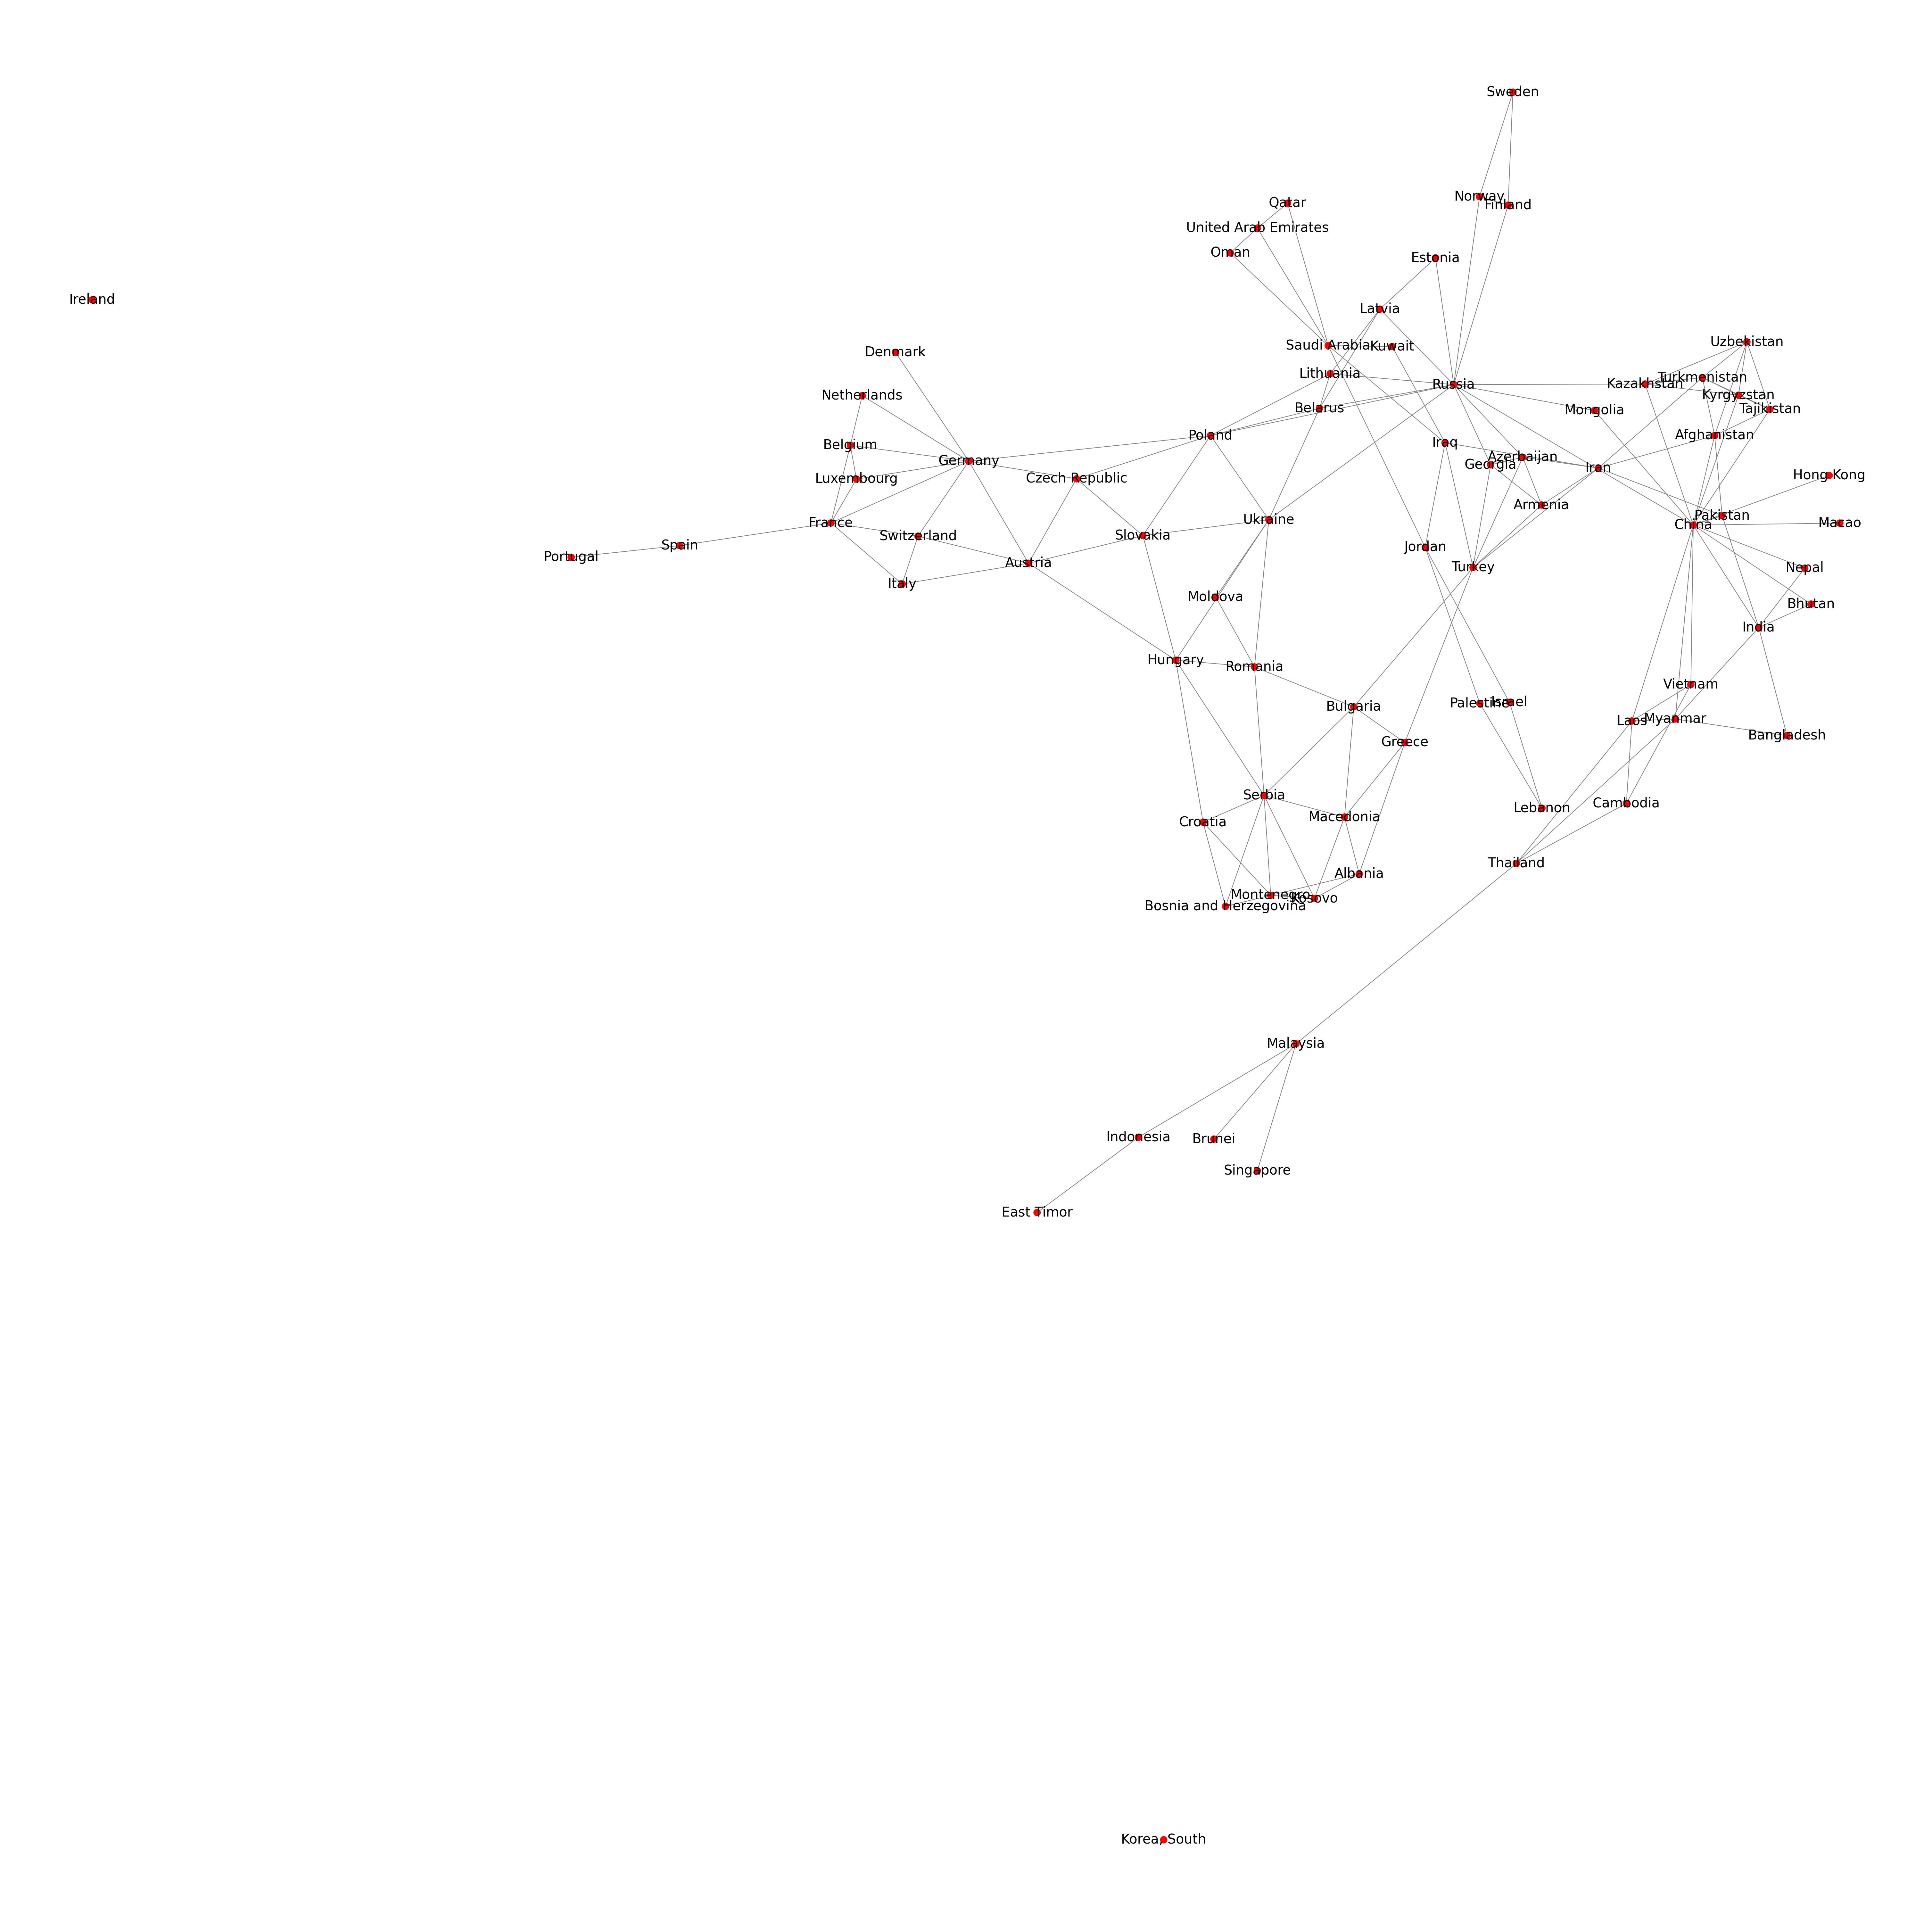

In [12]:
test_graph = f_graph(array_adjacency[1],df_network_country,p_group_of_countries = list(df_network_country.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, p_weight = "length")

nodes: 77
edges: 154


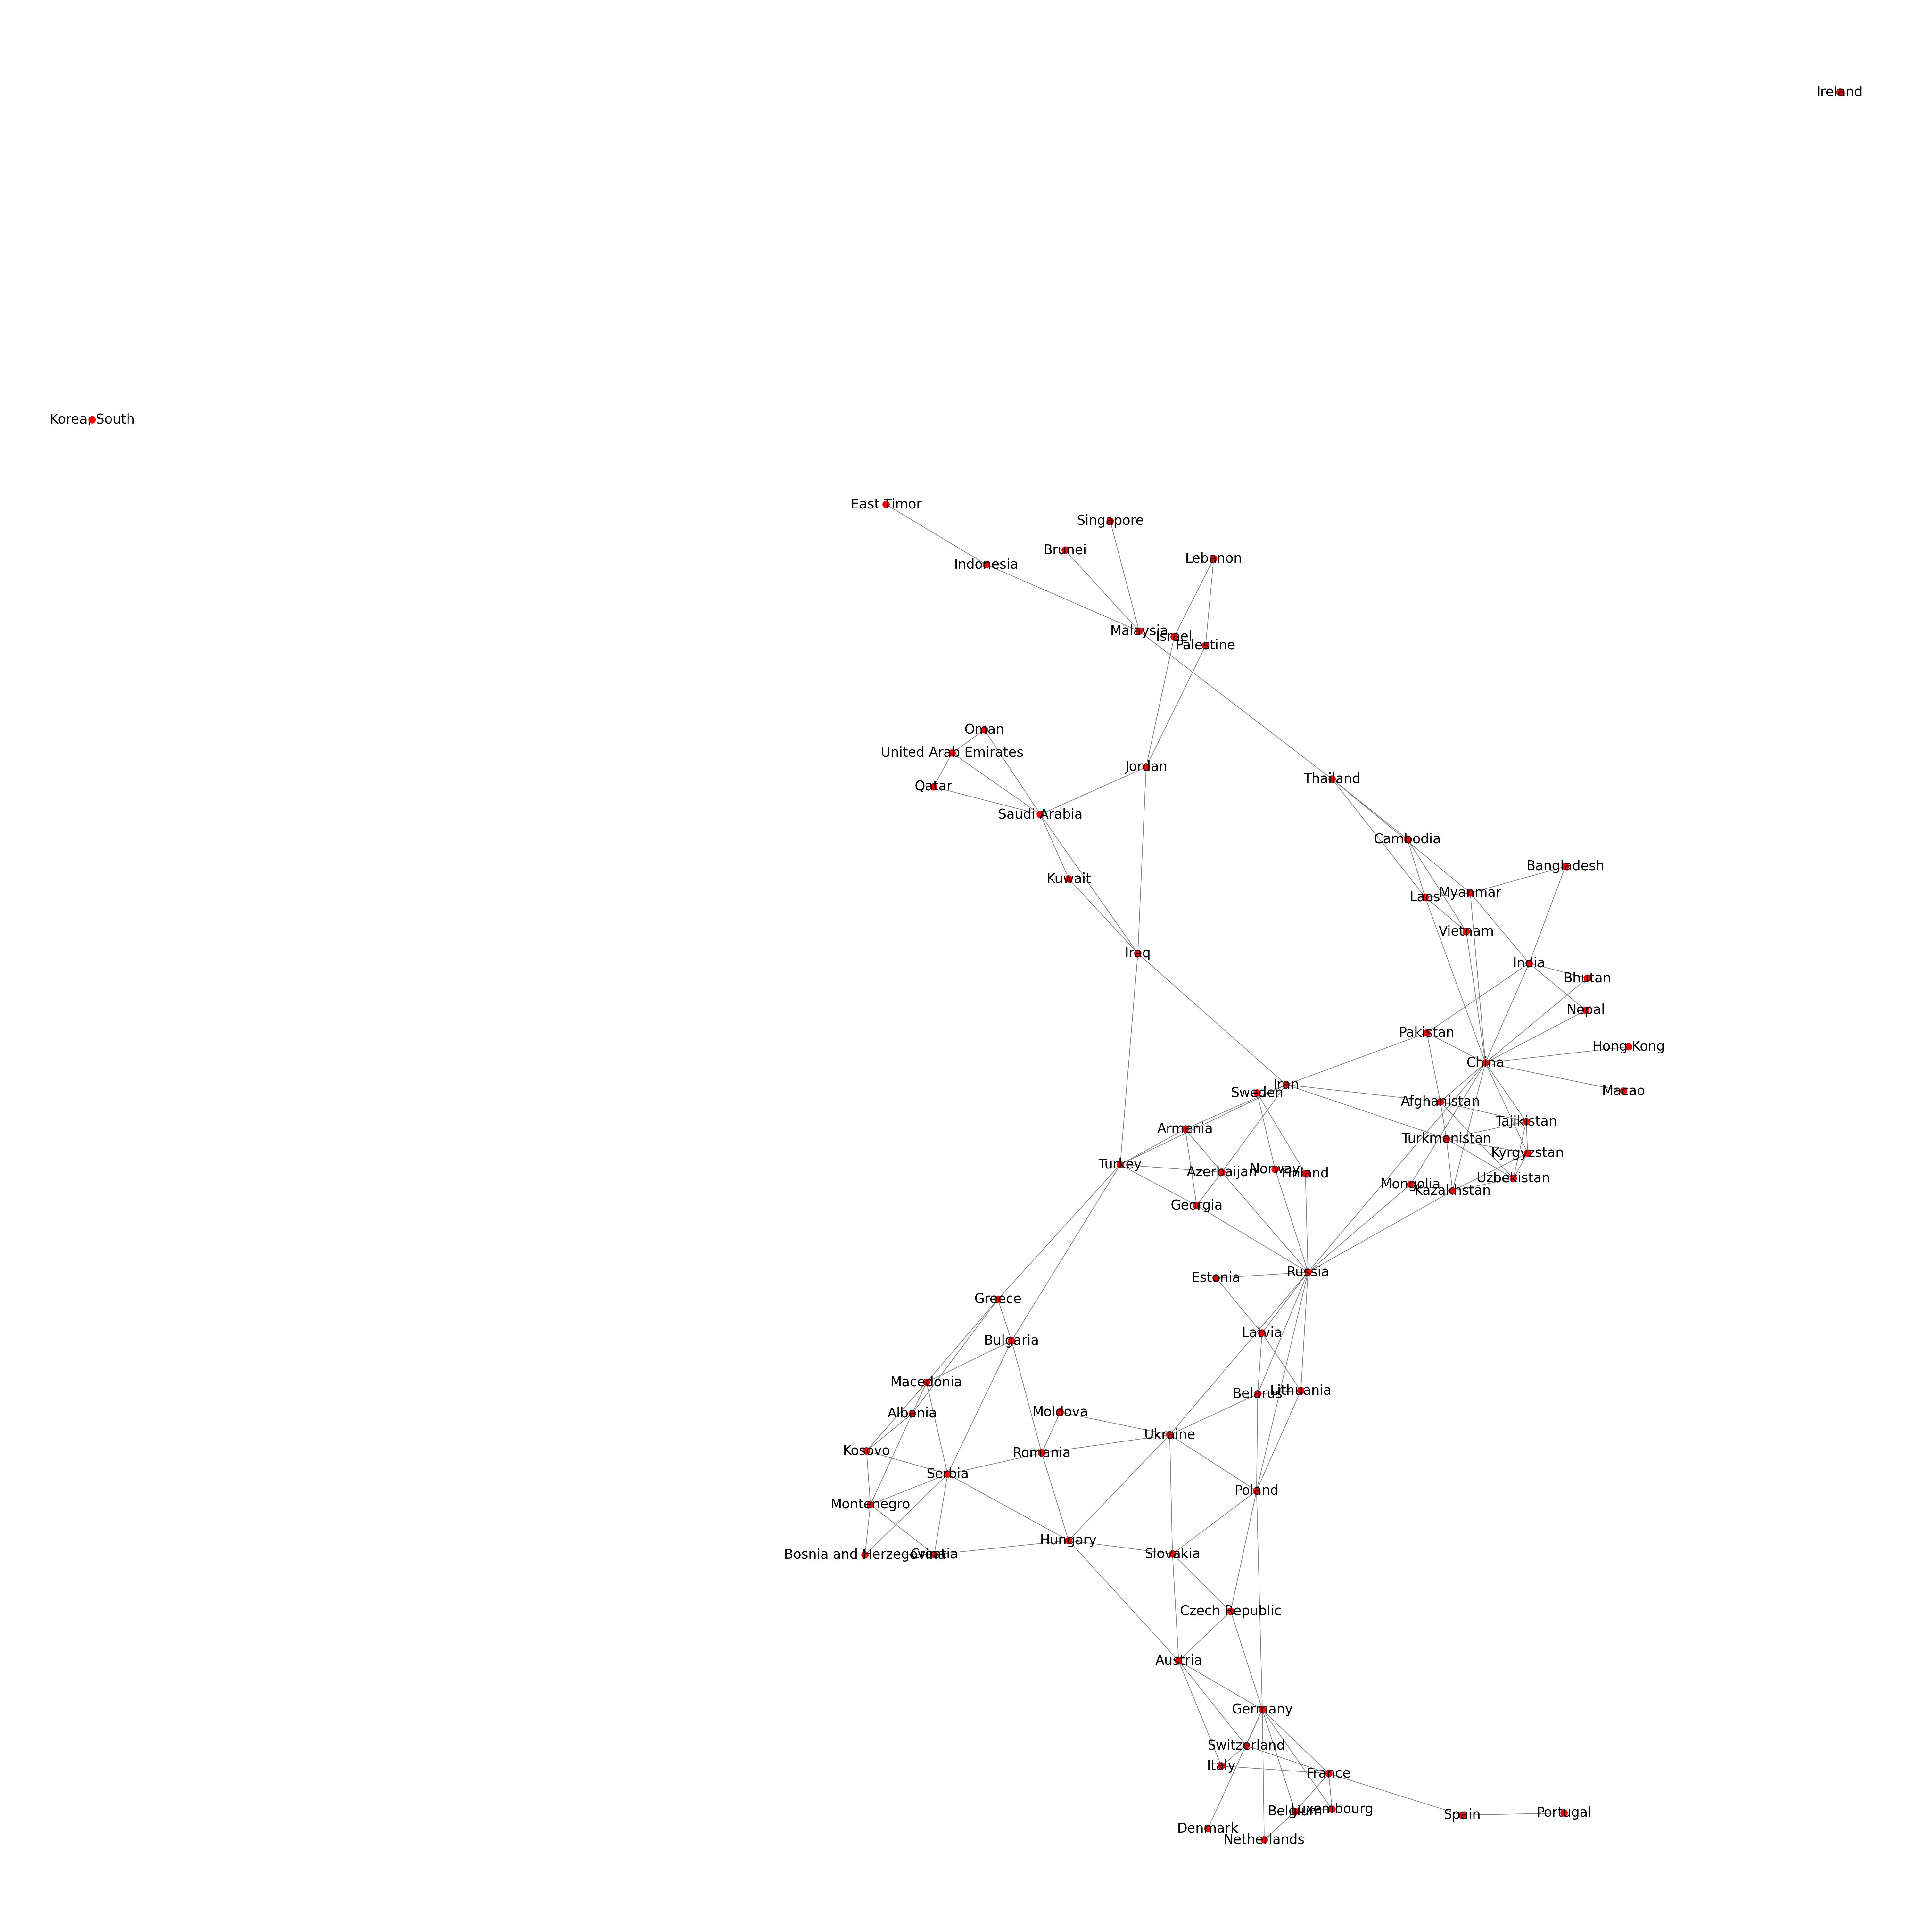

Density: 0.05263157894736842


In [20]:
graph_object = s_adj_matrix_plot.f_graph(array_adjacency[1],p_group_of_countries = list(df_network_country.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, p_weight = "di"                     
                         )
print(f"Density: {nx.density(graph_object)}")

In [14]:
# Shortest path test
print(nx.nx.single_source_dijkstra(test_graph,"China","Spain",weight ="de"))

(446687059.4851446, ['China', 'Kazakhstan', 'Russia', 'Poland', 'Slovakia', 'Czech Republic', 'Germany', 'Belgium', 'France', 'Spain'])


In [15]:
# betweeness
betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(test_graph)
edge_betweenness_centrality = nx.algorithms.centrality.edge_betweenness_centrality(test_graph)

In [16]:
# Centrality
centrality = nx.algorithms.centrality.degree_centrality(test_graph)

In [17]:
# Experimental
nx.algorithms.centrality.subgraph_centrality(test_graph)

{'Afghanistan': 28.155649376022804,
 'China': 72.9409501123012,
 'Iran': 22.57063780264793,
 'Pakistan': 14.88145294086603,
 'Tajikistan': 25.159437664593803,
 'Turkmenistan': 26.82683233285409,
 'Uzbekistan': 22.065413490364726,
 'Albania': 9.252981743043376,
 'Greece': 9.185072352189895,
 'Kosovo': 11.19549623403855,
 'Macedonia': 13.911946869348021,
 'Montenegro': 13.687473525048961,
 'United Arab Emirates': 4.731037517964608,
 'Oman': 3.3899109238261524,
 'Qatar': 3.3899109238261507,
 'Saudi Arabia': 9.954493155950669,
 'Armenia': 12.496274689435321,
 'Azerbaijan': 17.555791403220244,
 'Georgia': 12.893336973384109,
 'Turkey': 20.531814981494577,
 'Austria': 17.387252944040274,
 'Switzerland': 11.254503256405375,
 'Czech Republic': 12.738976639347733,
 'Germany': 27.647273866360052,
 'Hungary': 18.128832707927806,
 'Italy': 6.848670446685148,
 'Slovakia': 16.553165697883763,
 'Russia': 58.88040722899098,
 'Belgium': 10.119034122238908,
 'France': 15.083982775562669,
 'Luxembourg': 

In [18]:
nx.density(test_graph)

0.05263157894736842

In [19]:
break

SyntaxError: 'break' outside loop (<ipython-input-19-6aaf1f276005>, line 4)

In [ ]:
def f_graph(p_tuples,p_group_of_countries = None,p_colour_group = "yellow", p_colour_default = "blue", p_edge_colour = "red"):

    """This function takes in the list of tuples from f_adj_matrix() (should be at index [1])
    Plus list of countries (full name, i.e. country_o or country_d columns) for colournig, else defaults to blue nodes"""
    import networkx as nx

    #=== Set up network
    f_G = nx.Graph()

    # Add nodes based on full country names
    #f_G.add_nodes_from(p_uniques)

    #=== base for checking nodes and edges
    def f_add_node_and_edge(p_graph,p_central_node,p_node_list,p_length = 5):
        # list of edges
        temp_edges = []
        # list of neighbours
        p_node_list

        try:
            p_graph.add_node(p_central_node)
        except:
            pass

        for country in p_node_list:
            temp_tuple = (p_central_node,country)
            temp_edges.append(temp_tuple)

        p_graph.add_edges_from(temp_edges,length = p_length)

    #=== run function to add values
    for entry in p_tuples:
        f_add_node_and_edge(f_G,entry[0],entry[1])

    #=== node colouring | compare list of countries to be treated differently to list of nodes
    colour_list = []


    for entry in list(f_G.nodes):
        if entry in p_group_of_countries:
            colour_list.append(p_colour_group)
        else:
            colour_list.append(p_colour_default)
    #except:
     #   print("Colouring didn't work, defaulting to {p_col_default}")
      #  colour_list = p_colour_default

    #=== report
    print("nodes:",f_G.number_of_nodes())
    print("edges:",f_G.number_of_edges())


In [ ]:
f_G_out = f_graph(test_f_run[1],p_group_of_countries = list(network_df_vis.country_o.unique()))

In [ ]:
len(test_f_run[1])

In [ ]:
break

#### Filter on certain countries

Filter for all of asia:
```
trial_df = trial_df[
    ((trial_df.region_d.str.contains("asia")) | (trial_df.region_d.str.contains("east")))
    & 
    ((trial_df.region_o.str.contains("asia")) | (trial_df.region_o.str.contains("east")))
```

Filter for all countries that have a connection (avoid showing little islands or unconnected regions
```
trial_df = trial_df[(trial_df.contiguity == 1)]
```

In [ ]:
# Filters
europe_filter = (trial_df.region_d == "europe") & (trial_df.region_o == "europe")
europe_land_filter = (trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)
asia_all = ((trial_df.region_d.str.contains("asia")) | (trial_df.region_d.str.contains("east"))) & ((trial_df.region_o.str.contains("asia")) | (trial_df.region_o.str.contains("east")))
land_all = (trial_df.contiguity == 1)

#trial_df = trial_df[(trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)]

In [ ]:
# Preview data
trial_df = df_05_16[df_05_16.year == 2016]
trial_df = trial_df[(trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)]

trial_df.head()

<a id="ID_part3"></a>
### Part 3 | Produce matrix and network
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [ ]:
#temp_df test df working
test_f_run = mp.f_adj_matrix(trial_df,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")
mp.f_graph(test_f_run[1])